# Exploratory Analysis for Prediction of Hospital Readmission in Diabetes Patients

## Introduction 

This part of the project investigates relationships between variables in the (cleaned) data set through plots and descriptive statistics (e.g., means, proportions, distributions). These relationships include correlation, dependence, and other measures that may indicate predictive value. 

Where appropriate, we can use inferential statistics (hypothesis tests or confidence intervals) to test the significance of trends that emerge initially. The results will give a sense of which variables could be most important in final analyses and may also point to an important issue called multicollinearity. This issue occurs when two independent variables provide very similar information, creating a sort of redundancy that needs to be addressed before final analyses.

In [6]:
%matplotlib inline
import pandas as pd 
import numpy as np
import scipy.stats as scs
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style = "ticks", color_codes = True)

pd.set_option('display.max_columns', 50) #display all columns of data frame (df) 

#read in cleaned data and preview df
EDA = pd.read_csv('readmit_for_map.csv')
EDA.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmit30,num_visits,first_diag,second_diag,third_diag
0,Caucasian,Female,[50-60),2,1,1,8,77,6,33,0,0,0,8,None,None,Steady,No,No,No,No,No,No,Down,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,1,2,circulatory,injury,digestive
1,Caucasian,Female,[50-60),3,1,1,2,49,1,11,0,0,0,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,1,musculoskeletal,other,diabetes
2,Caucasian,Female,[80-90),1,3,7,4,68,2,23,0,0,0,9,None,>7,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,1,injury,respiratory,other
3,Caucasian,Female,[80-90),1,1,7,3,46,0,20,0,0,0,9,None,>8,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Ch,Yes,0,1,neoplasms,circulatory,circulatory
4,AfricanAmerican,Female,[30-40),1,1,7,5,49,0,5,0,0,0,3,None,None,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,1,genitourinary,neoplasms,diabetes


## Balance of the Dependent Variable

The ratio of negative (not readmitted within 30 days) to positive (readmitted within 30 days) outcomes is calculated below. It is roughly 10:1.

This ratio -- the outcome variable's balance -- illustrates the overall likelihood of being readmitted within 30 days. It's useful context in looking at the independent variables because if the balance is much different from 10:1 within a particular feature, that feature may have significant predictive value.

In [3]:
#find balance in dependent variable 
EDA.groupby('readmit30').size()

readmit30
0    60770
1     6074
dtype: int64

## Relationships Among Independent Variables

Next, we check for high correlation between predictors. If such correlation exists, and two variables provide very similar information, then one would likely need to removed so that the shared information isn't overly weighted. For example, if age and number of medications are highly correlated, they will likely have similar relationships to readmission within 30 days. That type of relationship would then receive about twice the importance that other variables receive in final analyses, biasing the results. 

To start, let's look at a correlation matrix, which shows scatter plots for several pairs of variables at once. We'll check only four variables here so that the matrix isn't visually overwhelming. In this case, we consider number of procedures, number of medications, number of emergencies, and number of visits to a medical facility -- all features that could correlate highly with each other. 

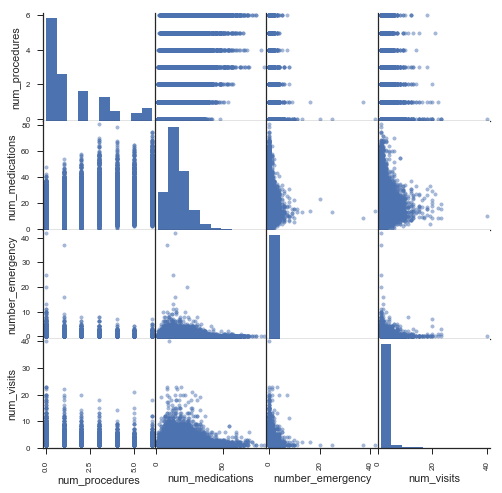

In [9]:
# Scatter matrix
sm = pd.scatter_matrix(EDA[['num_procedures', 'num_medications', 'number_emergency', 'num_visits']], figsize = (8, 8))
sns.despine()

In a clear correlation, a sort of cigar-shaped, linear pattern with heavy clustering in the middle would appear on a plot. None of the above plots shows such a pattern, though, so multicollinearity is likely not an issue for any feature pairs here. That said, it is worth noting that number of emergency admissions and number of medications show a curved, downward relationship, which indicates that these two variables may be exponentially -- though not linearly -- related. They appear to have a relationship, but it is not one that could indicate multicollinearity.

These plots show heavy clustering around low values, but little else in the way of convincing trends. Note that the plots resembling histograms (on the diagonal running from top left to bottom right) are for variables plotted against themselves, hence their unique appearances. 

Next, we'll consider the distribution of age as a predictor before looking more closely at its relationship with other variables. In addition to a first step toward more exploratory analysis, it will give us an overall sense of the age of patients in our data set, which is useful context going forward. 

Because many other medical variables could correlate with age, it may be instructive to look at it in isolation before checking scatter plots.

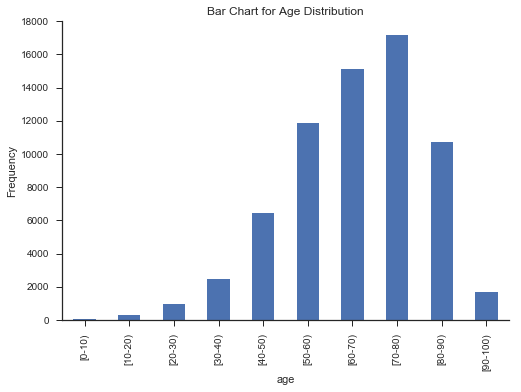

In [8]:
#bar chart for age
age_grouped = EDA.groupby(['age']).size()
age_grouped.plot(kind = 'bar')
sns.despine()
plt.ylabel('Frequency')
plt.title('Bar Chart for Age Distribution')
plt.show()

The patients skew older, so other variables that yield higher values for older patients could correlated highly with age and/or each other. Let's see if there is a relationship between age and our dependent variable, readmission within 30 days. 

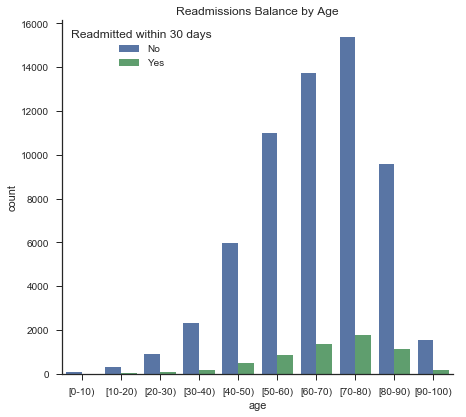

In [10]:
# generate sorted list to keep age bins in ascending order in plot
a = EDA.age.unique()
a.sort()
a_sort = np.array(a).tolist()

# paired bar plot to check b/w readmission within 30 days and age
A1C = sns.countplot(x = 'age', hue = 'readmit30', data = EDA, order = a_sort) 

sns.despine()
A1C.figure.set_size_inches(7, 6.5)
A1C.legend(title = 'Readmitted within 30 days', labels = ('No', 'Yes'))
A1C.axes.set_title('Readmissions Balance by Age')
plt.show()

In general, the number of readmitted patients increases with the number of non-readmitted patients for each age group, so percentages of readmitted patients look similar across age groups. The percentages are not perfectly constant, however: the 80-90 age bracket clearly has a higher percentage of readmitted patients. Thus, there may be some predictive value in higher age brackets. 

Next, it will help to look at possible correlation between age and number of medications; perhaps patients tend to need more medications as they get older. 

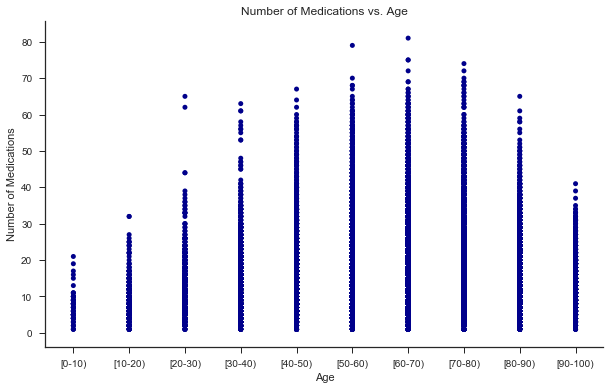

In [6]:
#make scatter plot for age and number of medications
age_sort = EDA.sort_values(by = 'age')
g = sns.stripplot(x = "age", y = "num_medications", data = age_sort, color = 'darkblue')
sns.despine() #remove top and right axes
g.figure.set_size_inches(10, 6)
g.set_xlabel('Age')
g.set_ylabel('Number of Medications')
g.axes.set_title('Number of Medications vs. Age')
plt.show()

The scatter plot indicates that there are more people in higher age groups taking higher numbers of medications, but all age groups show heavy clustering in lower numbers, too. Therefore, it's unlikely that age and number of medications are so highly correlated that one variable would need removal. 

Now let's see if there is an association between the number of days a patient spends in the in hospital and the number of procedures he or she has. If having more procedures done is simply a function of spending more days in the hospital, then one of these variables might be superfluous. 

A grouped bar graph will help examine this relationship. For each number of days spent in the hospital, we can see how many patients had a certain number of procedures. If there are more patients having fewer procedures when spending fewer days in the hospital and vice versa, for example, there could be a correlation. (Note to viewer: you can zoom in/out and move around in the plot below using the grey icons that appear at the bottom left of the plot when you hover over it.)

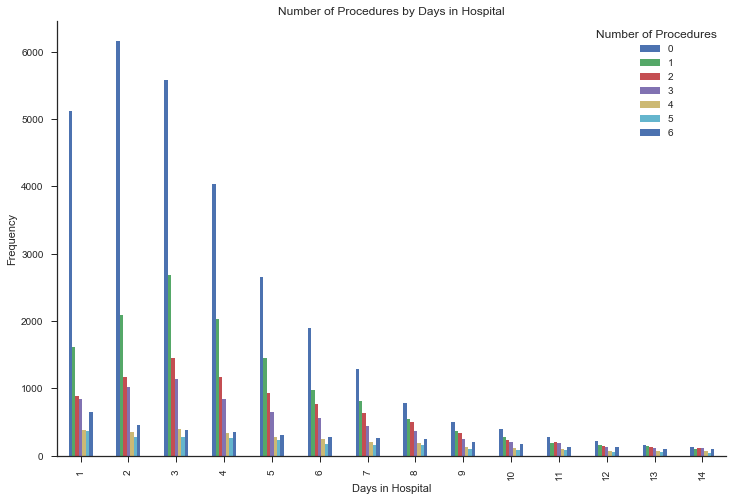

In [7]:
#cross tab and data frame for bar chart
num_procs_ct = pd.crosstab(index = EDA['days_in_hospital'], columns = EDA['num_procedures']) 
num_procs_df = pd.DataFrame(num_procs_ct.reset_index())

    #make paired bar chart 
import mpld3
mpld3.enable_notebook() #enables zooming and scrolling within charts

Nlevels = num_procs_df.days_in_hospital.tolist()
Nmapping = {level: i for i, level in enumerate(Nlevels)} #assign nos. to levels 
Nkey = num_procs_df['days_in_hospital'].map(Nmapping) #map level ordinals to their rows in df
Nsorting = num_procs_df.iloc[Nkey.argsort()] #create df w/ desired order from matched ordinals

p = Nsorting.plot(kind = 'bar', x = 'days_in_hospital', legend = 'Number of Procedures')
sns.despine()
p.figure.set_size_inches(12, 8)
p.set_xlabel('Days in Hospital')
p.set_ylabel('Frequency')
p.legend(title = 'Number of Procedures')
p.axes.set_title('Number of Procedures by Days in Hospital')
plt.show()

As the number of days in the hospital increases, frequency rises quickly before dropping swiftly for patients with lower numbers of procedures performed. However, the converse is not true: the frequency of patients with higher numbers of procedures does not increase with the number of days spent in the hospital. There is not much evidence for correlation or multicollinearity. 

## Relationships Between Independent Variables and Readmission Within 30 Days

The initial researchers using this data set were interested in determining if patients who had HbA1c levels tested were significantly less likely to be readmitted within 30 days. As such, it's worth checking for correlation between HbA1c testing and readmission. 

HbA1c result has four categories: 3 different levels and None, indicating that the test wasn't performed. The initial researchers looked at this variable as a categorical one in this fashion. Relevant percentages are calculated following the graph, and are all within 1% of those found by the original researchers.

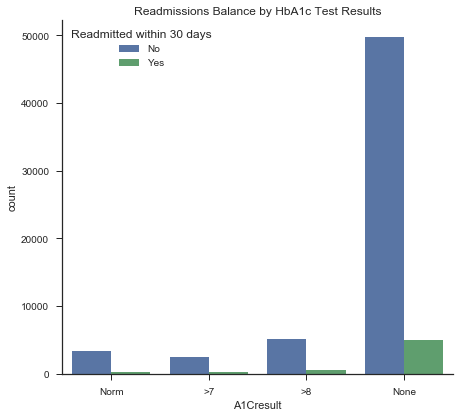

In [37]:
# create plot and specifications 
A1C = sns.countplot(x = 'A1Cresult', hue = 'readmit30', data = EDA, order = ['Norm', '>7', '>8', 'None']) 

sns.despine()
A1C.figure.set_size_inches(7, 6.5)
A1C.legend(title = 'Readmitted within 30 days', labels = ('No', 'Yes'))
A1C.axes.set_title('Readmissions Balance by HbA1c Test Results')
plt.show()

In [10]:
percents = {'none': 5033/(49718+5033), '>7': 237/(2535+237), '>8': 488/(5215+488), 'normal': 316/(3302+316)}
percents

{'>7': 0.0854978354978355,
 '>8': 0.08556899877257584,
 'none': 0.09192526163905682,
 'normal': 0.08734107241569929}

The graph and calculations above show a somewhat steady balance in readmissions across the levels of HbA1c tests, so there may be evidence of correlation. For more information, let's look at the data in binary format using a 2x2 table and a significance test for independence between the two variables. The significance test will indicate whether a possible correlation could have occurred by random chance. 

Note that in the table headings below, zero indicates no and one indicates yes for the relevant variable.

In [11]:
#create new, binary column to show whether HbA1c test performed or not
EDA['HbA1c'] = np.where(EDA['A1Cresult'] == 'None', 0, 1)

#cross tab of HbA1c test and readmission w/in 30 days 
HbA1c_ct = pd.crosstab(index = EDA['HbA1c'], columns = EDA['readmit30'], margins = True)
HbA1c_ct

readmit30,0,1,All
HbA1c,,,
0,49718,5033,54751
1,11052,1041,12093
All,60770,6074,66844


In [12]:
#find readmission rates for patients who did and did not have HbA1c test, and for all patients
test = 1041/12093
no_test = 5033/54751
all_patients = 6074/66844
test, no_test, all_patients

(0.08608285785164971, 0.09192526163905682, 0.09086829034767518)

8.6% of tested patients were readmitted within 30 days, compared to 9.2% of non-tested patients. The Chi-square test for independence will indicate if this difference is statistically significant, i.e., likely not due to chance.

In [13]:
#perform chi-square test for independence -- fix df row/col situation or use scipy approach w/ array-based table
                           
    #write function to create contingency table 
def chisq_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1) 
    return(scs.chi2_contingency(ctsum))

    #run test
chisq_cols(EDA, 'HbA1c', 'readmit30')

(4.0222625867469644,
 0.044903434870189884,
 1,
 array([[ 49775.87023517,  10994.12976483],
        [  4975.12976483,   1098.87023517]]))

Since the p-value from the test above is less than .05, we reject the null hypothesis that testing for HbA1c and readmission within 30 days are independent. More practically, this means that there is less than a 5% chance that this relationship is due to random chance. So even though the difference in percentages of readmitted patients for those tested and those not is fairly small, it is evidently not due to chance. HbA1c testing -- perhaps as binary and as multi-category outcome -- will be a key variable in final analyses.

Finally, since a new variable -- the number of visits by one patient to a medical facility -- was created, it would be nice to preview its relationship with the outcome variable. We'll do so using a paired bar chart again.

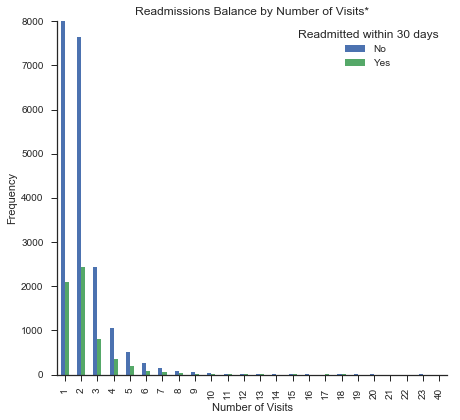

In [14]:
#create cross-tab for initial evaluation and make data frame for bar plot
visits_ct = pd.crosstab(index = EDA['num_visits'], columns = EDA['readmit30'])
visits_df = pd.DataFrame(visits_ct.reset_index())

#make bar chart 
Vlevels = visits_df.num_visits.tolist()
Vmapping = {level: i for i, level in enumerate(Vlevels)} 
Vkey = visits_df['num_visits'].map(Vmapping) 
Vsorting = visits_df.iloc[Vkey.argsort()] 
v = Vsorting.plot(kind = 'bar', x = 'num_visits')
sns.despine()

v.figure.set_size_inches(7, 6.5)
v.set_ylim([0, 8000])
v.set_xlabel('Number of Visits')
v.set_ylabel('Frequency')
v.legend(title = 'Readmitted within 30 days', labels = ('No', 'Yes'))
v.axes.set_title('Readmissions Balance by Number of Visits*')
plt.show()

With the exception of patients who had 2 visits, this graph shows an exponential, negative trend between readmissions frequency and number of hospital visits. This newly created variable may have predictive power. 

*Note that the number of non-readmitted patients for 1 visit is nearly 50,000, but the y-axis of the graph here is truncated to improve readability. Higher numbers of patient visits have very few observations, but their bars can be viewed using the zoom tool that appears when hovering over the lower-left part of the window above.